In [51]:
#!pip install transformers
#!pip install nltk
#!pip install sklearn
#!pip install seaborn
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

In [50]:
import seaborn as sns

#Libraries for text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

#Importing Tensorflow for model creation
import tensorflow as tf

#Libraries that check the accuracy of the model over test set
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

In [34]:
df = pd.read_csv('train.csv')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [36]:
# Combining the title of the news with it's text

df["text"] = df["text"]+" "+df["title"]

In [37]:
# Drop the unnecessary columns, title(already added to the text column) and author

df.drop(["title", "author"], axis = 1, inplace = True)

In [15]:
#Defining functions to clean text data

def remove_punctuation(text):  #Removing any kind of punctuation present in the data
    return re.sub(r'[^\w\s]','', str(text))
                  
def remove_urls(text):  #Removing urls from the data
    return re.sub(r"http\S+", " ", str(text))
                  
def remove_stopwords(text):  #Removing stopwords(eg. this, that, am, be etc)
    stop = stopwords.words("english")
    final_text = []
    for i in str(text).split():
        if i.strip() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
                  
def tokenize(text):  
    tokens = re.split('\W+',text) #W+ means that either a word character (A-Z) or a dash(-) can go there.
    return tokens

def tokenize_words(text):  #Converting all the text to lower case
    return word_tokenize(text.lower())

                                  
def stemming(text):  #Converting the words into their stem form
    porter_stemmer = PorterStemmer()
    return porter_stemmer.stem(str(text))
                  
def lemmatization(text):  #Applying Lemaatization i.e., converting words into their lemma
    wordnet_lemmatizer = WordNetLemmatizer()
    return wordnet_lemmatizer.lemmatize(str(text))

In [39]:
def clean_text(text):
    text = remove_punctuation(text)
    text = remove_urls(text)
    text = remove_stopwords(text)
    text = tokenize_words(text)
    text = stemming(text)
    return lemmatization(text)

df['text'] = df['text'].apply(lambda x: clean_text(x))

In [40]:
# Splitting the dataset into train and test set

x_train, x_test, y_train, y_test = train_test_split(df["text"], df["label"], test_size = 0.25, random_state = 11)

In [41]:
#Tokenize the words into vectors because we can only give numerical data as input to the model

max_vocab = 25000
tokenizer = Tokenizer(num_words = max_vocab)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [42]:
#Padding is applied so that we get the same length of input for each article

x_train = pad_sequences(x_train, padding = "post", maxlen = 256)
x_test = pad_sequences(x_test, padding = "post", maxlen = 256)

In [43]:
# Creating the RNN model

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         3200000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 3,319,553
Trainable params: 3,319,553
Non-trainable params: 0
____________________________________________

In [44]:
# Training the model

model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
             optimizer = tf.keras.optimizers.Adam(1e-4),
             metrics = ["accuracy"])

model.fit(x_train, y_train, epochs = 4, validation_split = 0.2, batch_size = 32, shuffle = True)

Epoch 1/4
390/390 [==============================] - 23s 44ms/step - loss: 0.4344 - accuracy: 0.7413 - val_loss: 0.1522 - val_accuracy: 0.9548
Epoch 2/4
390/390 [==============================] - 15s 40ms/step - loss: 0.1126 - accuracy: 0.9663 - val_loss: 0.1043 - val_accuracy: 0.9667
Epoch 3/4
390/390 [==============================] - 15s 40ms/step - loss: 0.0601 - accuracy: 0.9835 - val_loss: 0.0820 - val_accuracy: 0.9724
Epoch 4/4
390/390 [==============================] - 15s 39ms/step - loss: 0.0393 - accuracy: 0.9897 - val_loss: 0.0821 - val_accuracy: 0.9731


In [45]:
# Evaluating the test set

model.evaluate(x_test, y_test)

163/163 [==============================] - 3s 19ms/step - loss: 0.0801 - accuracy: 0.9710


[0.0800672322511673, 0.9709615111351013]

In [46]:
y_pred = model.predict(x_test)

binary_prediction = []

for i in y_pred:
    if i>=0.5:
        binary_prediction.append(1)
    else:
        binary_prediction.append(0)

In [47]:
# Checking model accuracy

print('Accuracy on testing set:', accuracy_score(binary_prediction, y_test))
print('Precision on testing set:', precision_score(binary_prediction, y_test))
print('Recall on testing set:', recall_score(binary_prediction, y_test))

Accuracy on testing set: 0.9709615384615384
Precision on testing set: 0.9694980694980695
Recall on testing set: 0.9721254355400697


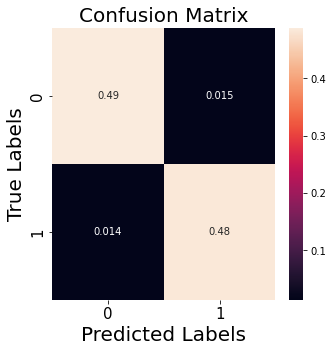

In [53]:
# Creating a heatmap to visualize the confusion matrix

matrix = confusion_matrix(binary_prediction, y_test, normalize='all')
plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);